<a href="https://colab.research.google.com/github/Justabhi96/advanced_computer_vision/blob/master/09_Object_Localization_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Make the pokemon of different sizes also flip the pokemon randomly with arbitrary background
## Also make pokemon disppear from some samples

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0


In [2]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2020-02-11 17:08:51--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2020-02-11 17:08:52 (85.2 MB/s) - ‘charmander-tight.png’ saved [3952/3952]

--2020-02-11 17:08:56--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K   45

In [0]:
!unzip -q backgrounds.zip

In [4]:
import os
os.listdir("backgrounds")

['14.jpg',
 '7.jpg',
 '5.jpg',
 '10.jpg',
 '3.jpg',
 '12.jpg',
 '15.jpg',
 '13.jpg',
 '4.jpg',
 '8.jpg',
 '9.jpg',
 '6.jpg',
 '11.jpg',
 '1.jpg',
 '2.jpg']

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import binary_crossentropy

In [0]:
IMAGE_SIZE = [200, 200, 3]

In [0]:
from glob import glob
backgrounds = []
background_files = glob("backgrounds/*.jpg")
for filename in background_files:
  # they all may not be same size
  bk_img = imageio.imread(filename)
  backgrounds.append(bk_img)

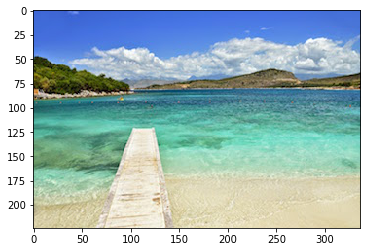

In [8]:
plt.imshow(backgrounds[2])

In [0]:
vgg = VGG16(input_shape = IMAGE_SIZE, weights = "imagenet", include_top = False)

x = Flatten()(vgg.output)
x = Dense(5, activation = "sigmoid")(x)
model = Model(vgg.input, x)

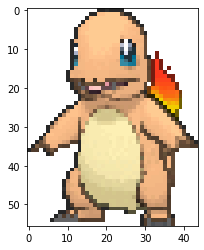

In [10]:
ch_image = imageio.imread("charmander-tight.png")
plt.imshow(ch_image)

In [11]:
ch_image = np.array(ch_image)
ch_h, ch_w, _ = ch_image.shape
ch_h, ch_w

(56, 44)

In [0]:
from skimage.transform import resize
ref_size = IMAGE_SIZE[0]

def image_generator(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros([batch_size] + IMAGE_SIZE)
      Y = np.zeros([batch_size, 5])

      for i in range(batch_size):
        bg = backgrounds[np.random.choice(len(backgrounds))]
        bg_h, bg_w, _ = bg.shape

        rand_h = np.random.randint(0, bg_h - ref_size)
        rand_w = np.random.randint(0, bg_w - ref_size)

        X[i] = bg[rand_h: rand_h+ref_size, rand_w: rand_w+ref_size].copy()

        appear = np.random.random() < 0.75
        if appear:
          # to make charmander bigger or smaller
          scale = 0.5 + np.random.random() #[0.5, 1.5]
          new_h = int(ch_h * scale)
          new_w = int(ch_w * scale)

          new_ch_img = resize(ch_image, (new_h, new_w), 
                              preserve_range=True).astype(np.uint8) # to keep the range 0 - 255
          if np.random.random() < 0.5:
            new_ch_img = np.fliplr(new_ch_img)

          row0 = np.random.randint(0, ref_size - new_h)
          col0 = np.random.randint(0, ref_size - new_w)
          row1 = row0 + new_h
          col1 = col0 + new_w

          # to paste charmander in background without removing background
          mask = (new_ch_img[:,:,3] == 0) # find where pokemon is zero
          bg_slice = X[i, row0:row1, col0:col1, :] # where we want to place the pokemon
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1)*(h,w,3)
          bg_slice += new_ch_img[:,:,:3] # add the pokemon to the slice
          X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

          Y[i, 0] = row0/ref_size
          Y[i, 1] = col0/ref_size
          Y[i, 2] = (col1-col0)/ref_size
          Y[i, 3] = (row1-row0)/ref_size
        
        # whether pokemon appear or not
        Y[i, 4] = appear

      yield X/255.0, Y

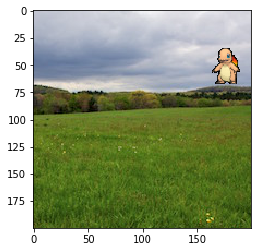

In [15]:
xx = None
yy = None
for x, y in image_generator():
  xx, yy = x, y
  break
plt.imshow(xx[10])

In [0]:
def cust_loss(ytrue, ypred):
  # target is 5 values 
  bce = binary_crossentropy(ytrue[:, :-1], ypred[:, :-1]) # loss for coords

  # loss for binary classification(object present or not)
  bce2 = binary_crossentropy(ytrue[:, -1], ypred[:, -1]) 

  return 2 * bce * ytrue[:,-1] + 0.5 * bce2

In [26]:
model.compile(optimizer=Adam(lr = 0.0001), loss = cust_loss)
model.fit_generator(image_generator(), epochs = 5, steps_per_epoch=50)

  ...
    to  
  ['...']
Train for 50 steps
Epoch 1/5
50/50 [==============================] - 44s 884ms/step - loss: 0.9140
Epoch 2/5
50/50 [==============================] - 39s 772ms/step - loss: 0.8211
Epoch 3/5
50/50 [==============================] - 39s 782ms/step - loss: 0.8018
Epoch 4/5
50/50 [==============================] - 39s 779ms/step - loss: 0.8226
Epoch 5/5
50/50 [==============================] - 39s 782ms/step - loss: 0.8327


In [0]:
from matplotlib.patches import Rectangle

def make_prediction():
  bg = backgrounds[np.random.choice(len(backgrounds))]
  bg_h, bg_w, _ = bg.shape

  rand_h = np.random.randint(0, bg_h - ref_size)
  rand_w = np.random.randint(0, bg_w - ref_size)

  x = bg[rand_h: rand_h+ref_size, rand_w: rand_w+ref_size].copy()

  appear = np.random.random() < 0.75
  if appear:
    # to make charmander bigger or smaller
    scale = 0.5 + np.random.random() #[0.5, 1.5]
    new_h = int(ch_h * scale)
    new_w = int(ch_w * scale)

    new_ch_img = resize(ch_image, (new_h, new_w), 
                        preserve_range=True).astype(np.uint8) # to keep the range 0 - 255
    if np.random.random() < 0.5:
      new_ch_img = np.fliplr(new_ch_img)

    row0 = np.random.randint(0, ref_size - new_h)
    col0 = np.random.randint(0, ref_size - new_w)
    row1 = row0 + new_h
    col1 = col0 + new_w

    # to paste charmander in background without removing background
    mask = (new_ch_img[:,:,3] == 0) # find where pokemon is zero
    bg_slice = x[row0:row1, col0:col1, :] # where we want to place the pokemon
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1)*(h,w,3)
    bg_slice += new_ch_img[:,:,:3] # add the pokemon to the slice
    x[row0:row1, col0:col1, :] = bg_slice # put the slice back

  X = np.expand_dims(x, 0)
  p = model.predict(X/255.0)[0]
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  if p[-1] <= 0.5:
    print("No object")
  else:
    y, x, w, h = p[0]*ref_size, p[1]*ref_size, p[2]*ref_size, p[3]*ref_size
    rect = Rectangle((x, y), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  plt.show()

No object


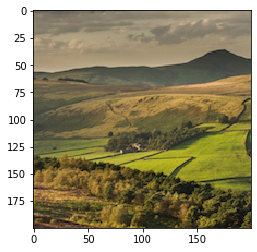

In [36]:
make_prediction()

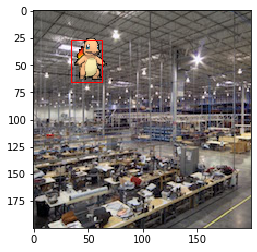

In [45]:
make_prediction()